In [1]:
import sys
sys.path.append('../')
import libs.db
import libs.prep_df
import pandas as pd
import sqlite3

In [2]:
tickers = libs.db.get_tickers("sp10.csv")
num_ticks = 60

In [3]:
sql_file = "sp10_historical.db"
conn = libs.db.create_connection(sql_file)
hist_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
hist_df = libs.prep_df.normalize_df(hist_df)

In [4]:
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(17080, 600)

In [5]:
#This function performs a pct_change on the hourly price data over a 16 row period.  The data from alpaca provides 16 hours of data for a 24-hour period, so this is the 24 hour return.
# It then shifts the pct_change back 16 rows so that the forward 24-hour return sits on the same timestamp as the current price.

hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_24_Return"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=16).shift(-16)
    hist_pct_returns_df_list.append(returns_df)
len(hist_pct_returns_df_list)

10

In [6]:
sql_file = "sp10_current.db"
conn = libs.db.create_connection(sql_file)
current_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
current_df = libs.prep_df.normalize_df(current_df)

In [7]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [8]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(17004, 610)

In [9]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)

In [10]:
y_start = len(tickers)*num_ticks

In [11]:
from sklearn.linear_model import LinearRegression
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)
lin_models = []
y_lin_predicted = []

In [12]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = LinearRegression()
    model.fit(X,y[i])
    lin_models.append(model)
    predicted = model.predict(X)
    y_lin_predicted.append(predicted)

In [13]:
from sklearn.metrics import r2_score
import numpy as np
r2 = [0]*len(tickers)
for i in range(0,len(tickers)):
    r2[i] = r2_score(y[i], y_lin_predicted[i])
    print(f"The r2 score for symbol {tickers[i]} is {r2[i]}")

The r2 score for symbol AAPL is 0.06463483383845314
The r2 score for symbol MSFT is 0.12854732111281575
The r2 score for symbol AMZN is 0.7134600667816808
The r2 score for symbol FB is 0.06340113586833651
The r2 score for symbol GOOGL is 0.07360604961932538
The r2 score for symbol TSLA is 0.0583069087544682
The r2 score for symbol BRK.B is 0.07914818434863213
The r2 score for symbol NVDA is 0.07267750297508213
The r2 score for symbol JPM is 0.0843572843674334
The r2 score for symbol JNJ is 0.07863815863089396


In [14]:
#Predict pct-change for each of the tickers over the month of June 2021
y_current_predicted = []
current_returns_df_list = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = lin_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)
    return_df = pd.DataFrame({"timestamp":current_pctchange_df.index, "prediction": predicted})
    return_df["buy"] = return_df['prediction'].apply(lambda x: 1 if x >= 0.0075 else 0)
    return_df = return_df.set_index("timestamp")
    return_df = return_df.merge(current_df[ticker], how="left", on="timestamp")

    money = 10000
    num_shares = 0
    state = 0
    buy_index = 0
    money_list=[]

    for i in range(0,len(return_df)):
        if state == 1 and i == buy_index + 16:
            #sell
            price = return_df.iloc[i,2]
            money = num_shares * price
            state = 0
            print(f"sell {ticker}", i ,price)

        if return_df.iloc[i,1] == 1 and state == 0 and i < len(return_df) - 16:
            #buy
            price = return_df.iloc[i,2]
            num_shares = money / price
            buy_index = i
            state = 1
            print(f"buy {ticker}", i, price)

        if return_df.iloc[i,1] == 1 and state == 1 and i < len(return_df) - 16:
            buy_index = i

        if state == 0 :
            money_list.append(money)
        else:
            price = return_df.iloc[i,2]
            money_list.append(num_shares*price)
    
    return_df["ROI"] = money_list

    current_returns_df_list.append(return_df)

buy AAPL 150 131.94
sell AAPL 180 131.65
buy MSFT 148 260.88
sell MSFT 172 261.92
buy AMZN 3 3206.0
sell AMZN 291 3438.0
buy GOOGL 249 2436.493
sell GOOGL 266 2438.56
buy TSLA 0 599.65
sell TSLA 31 603.5
buy TSLA 61 615.171
sell TSLA 80 610.01
buy TSLA 98 616.0
sell TSLA 120 597.2501
buy TSLA 125 603.2
sell TSLA 141 619.9253
buy TSLA 141 619.9253
sell TSLA 174 628.24
buy TSLA 202 652.44
sell TSLA 219 693.9
buy TSLA 249 685.7965
sell TSLA 268 679.9966
buy NVDA 49 693.99
sell NVDA 66 697.25
buy NVDA 77 716.0529
sell NVDA 116 710.2
buy NVDA 151 754.0
sell NVDA 178 734.0
buy NVDA 229 773.14
sell NVDA 269 794.52
buy JPM 28 165.31
sell JPM 44 162.98
buy JPM 154 148.06
sell JPM 170 150.92


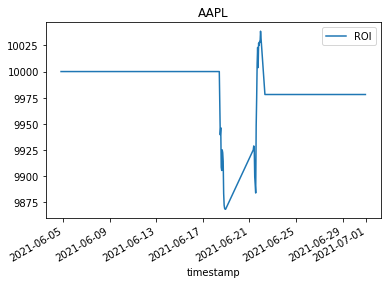

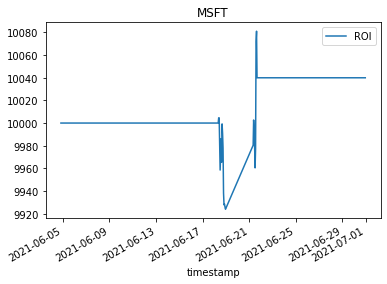

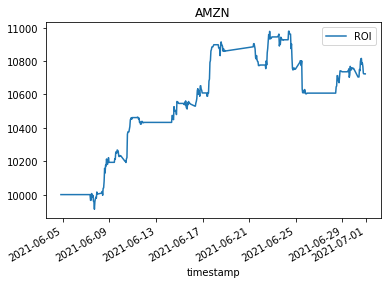

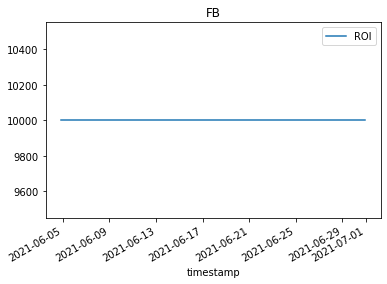

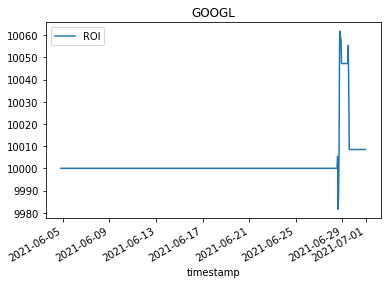

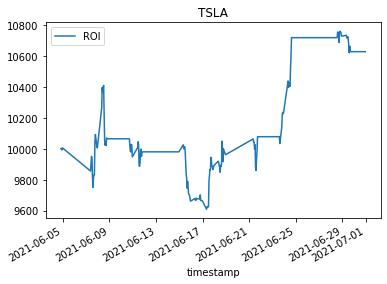

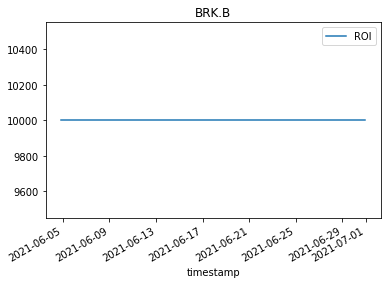

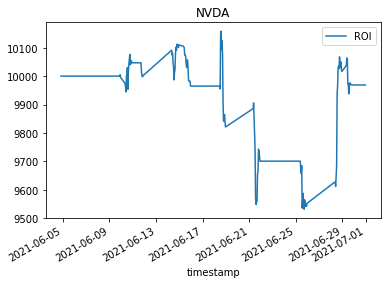

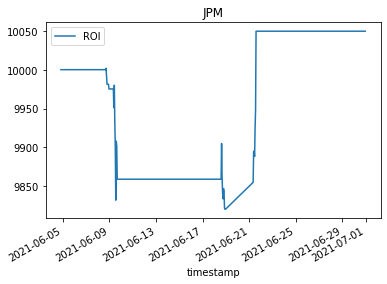

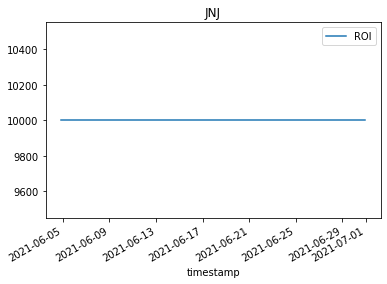

In [15]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    current_returns_df_list[i].plot(y="ROI", title=ticker)

In [16]:
starting_amount = 10000*len(tickers)
ending_amount = 0
for i in range(0,len(tickers)):
    ending_amount += current_returns_df_list[i].iloc[-1,-1]
ending_amount

101395.71920271633